In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

In [2]:

# Read the first few lines of the JSONL file and determine number of lines and columns
# jsonl_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/gen_bo1.jsonl"
jsonl_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/scored_bo2.jsonl"

# Read JSONL file into DataFrame in a compatible way
with open(jsonl_path, "r") as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)

# Exploratory Data Analysis
df_bon_beam

- 4998 unique questions from numina-math: it has the columns (question, method,	N,	beam_width,	max_iteration,	sl (aka, soft label), token_count, time, and sb_idx (aka, question id)).

In [2]:
# df_bon_beam.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_df.csv", index=False)
df_bon_beam = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_df.csv")

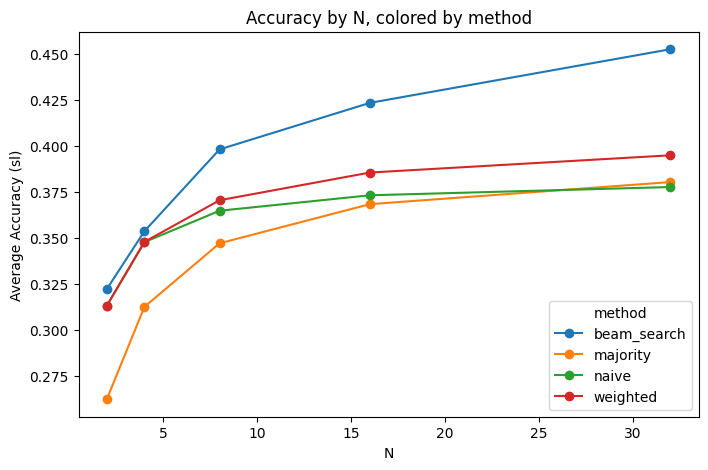

In [6]:
# accuracy over the entire dataset.
import matplotlib.pyplot as plt

avg_acc = df_bon_beam.groupby(["N", "method"])["sl"].mean().reset_index()
plt.figure(figsize=(8,5))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(group_sorted["N"], group_sorted["sl"], marker="o", label=method)
plt.xlabel("N")
plt.ylabel("Average Accuracy (sl)")
plt.title("Accuracy by N, colored by method")
plt.legend(title="method")
plt.show()

/tmp/ipykernel_1451554/1541306669.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)
/tmp/ipykernel_1451554/1541306669.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)


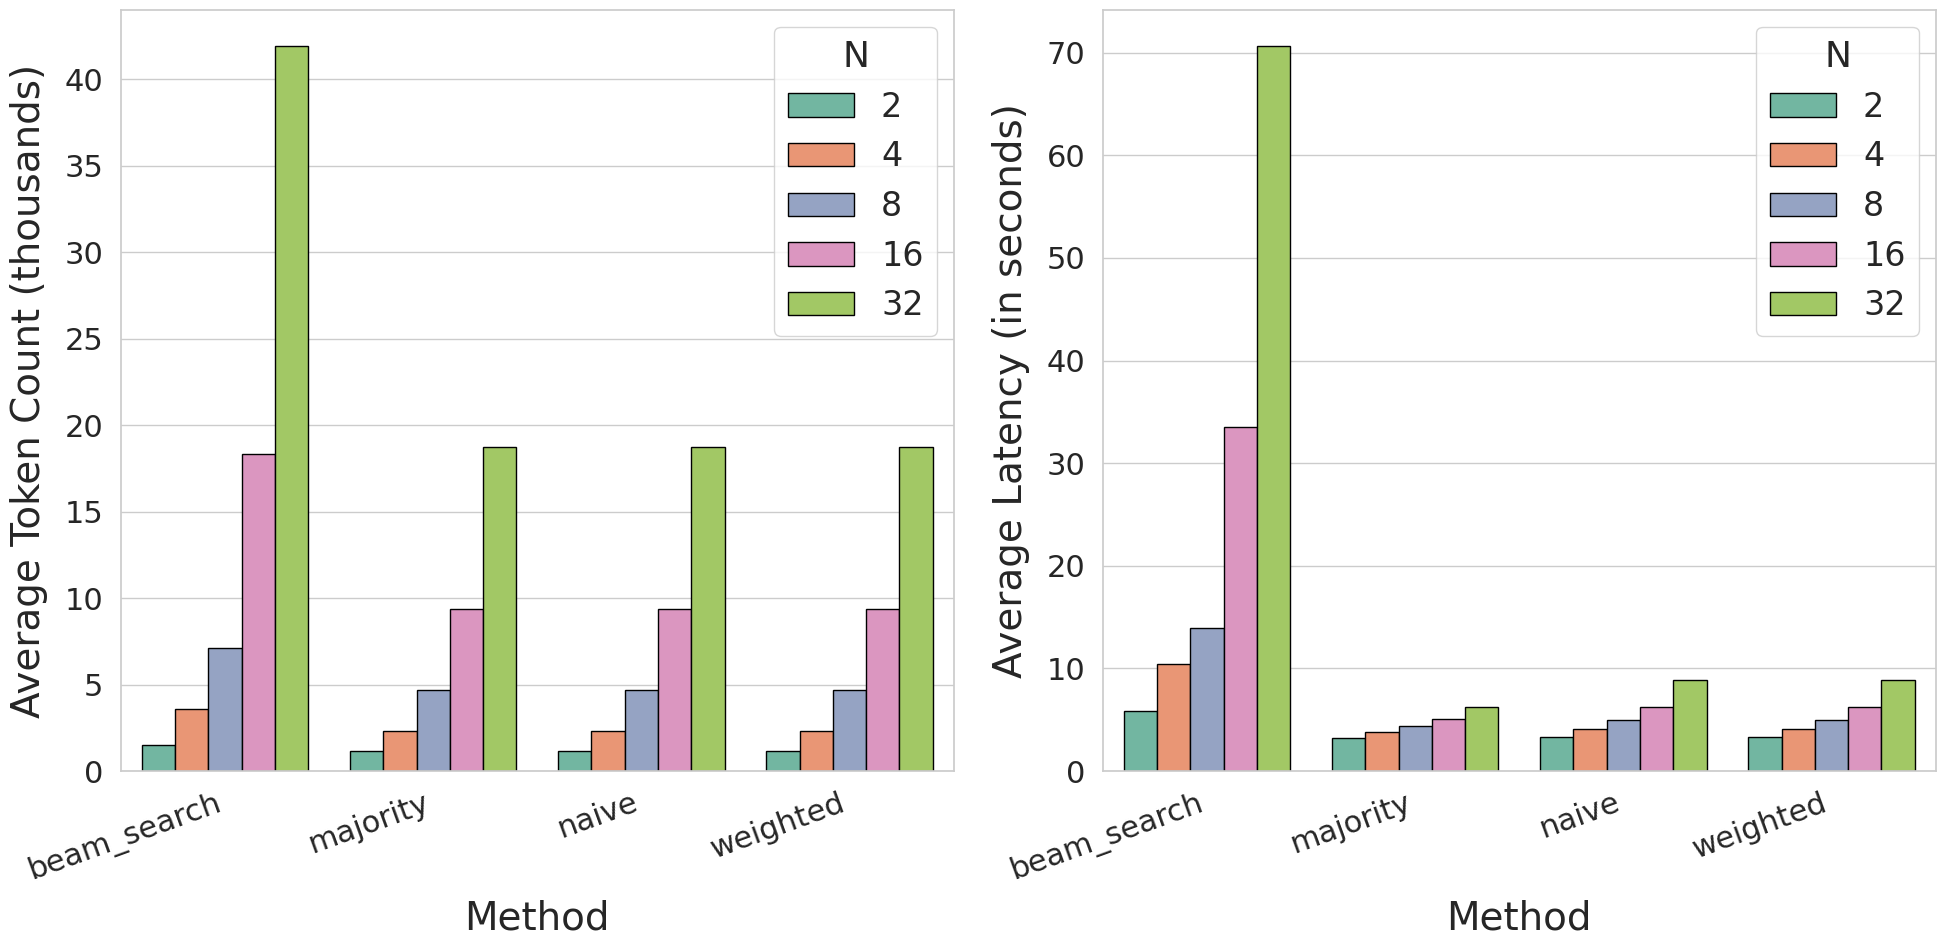

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set even larger font sizes for all elements
sns.set(style="whitegrid", font_scale=2.0)  # Increase font_scale for larger fonts

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Larger figure for clarity

palette = sns.color_palette("Set2", n_colors=len(df_bon_beam["N"].unique()))

# token_count plot (in thousands)
df_token = df_bon_beam.groupby(["method", "N"])["token_count"].mean().reset_index()
df_token["token_count_k"] = df_token["token_count"] / 1000  # convert to thousands

# Convert N to int for legend (removes .0)
df_token["N_int"] = df_token["N"].astype(int)

sns.barplot(
    data=df_token,
    x="method",
    y="token_count_k",
    hue="N_int",
    ax=axs[0],
    palette=palette,
    edgecolor="black"
)
axs[0].set_ylabel("Average Token Count (thousands)", fontsize=28, labelpad=12)
axs[0].set_xlabel("Method", fontsize=28, labelpad=10)
# axs[0].set_title("Average token_count by Method and N", fontsize=30)
axs[0].legend(title="N", loc="upper right", frameon=True, fontsize=24, title_fontsize=26)

# Remove decimals from y-axis tick labels for token count
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

# time plot
df_time = df_bon_beam.groupby(["method", "N"])["time"].mean().reset_index()
df_time["N_int"] = df_time["N"].astype(int)

sns.barplot(
    data=df_time,
    x="method",
    y="time",
    hue="N_int",
    ax=axs[1],
    palette=palette,
    edgecolor="black"
)
axs[1].set_ylabel("Average Latency (in seconds)", fontsize=28, labelpad=12)
axs[1].set_xlabel("Method", fontsize=28, labelpad=10)
# axs[1].set_title("Average time by Method and N", fontsize=30)
axs[1].legend(title="N", loc="upper right", frameon=True, fontsize=24, title_fontsize=26)

# Remove decimals from y-axis tick labels for time plot
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22, width=2.5, length=9)
    ax.tick_params(axis='both', which='minor', labelsize=20, width=2, length=6)
    # Remove set_yticklabels to avoid UserWarning

plt.tight_layout()
plt.show()

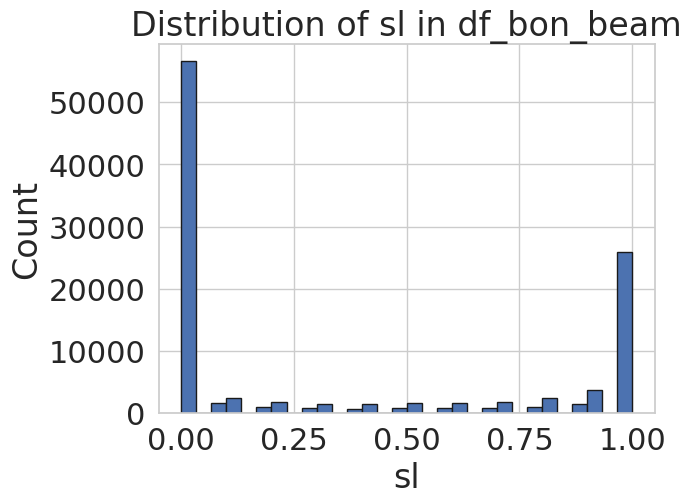

In [8]:
plt.hist(df_bon_beam['sl'], bins=30, edgecolor='k')
plt.xlabel('sl')
plt.ylabel('Count')
plt.title('Distribution of sl in df_bon_beam')
plt.show()

We will route between 22 configurations per question.

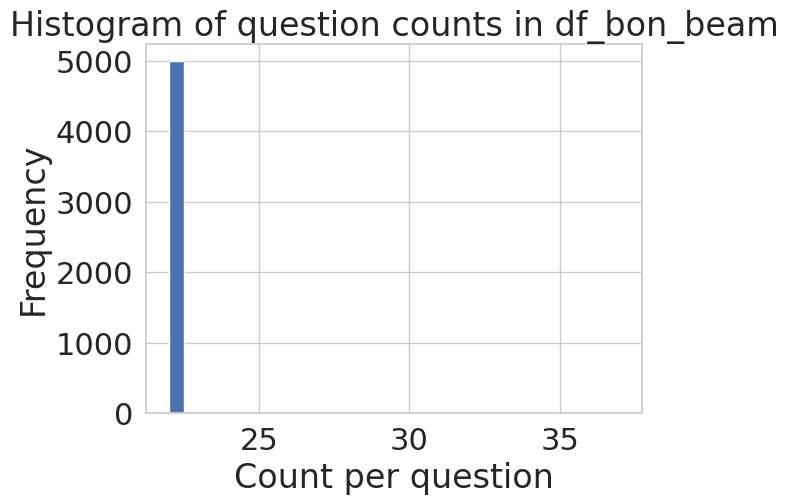

In [9]:
import matplotlib.pyplot as plt

df_bon_beam['question'].value_counts().hist(bins=30)
plt.xlabel("Count per question")
plt.ylabel("Frequency")
plt.title("Histogram of question counts in df_bon_beam")
plt.show()

# Routing

In [3]:
# create a train test split, and keep track of indices.
from sklearn.model_selection import train_test_split

# create train/test split based on 'sb_idx' (query identifier)

unique_sb_idx = df_bon_beam['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=9 # 6
)

# Divide queries (represented by sb_idx) into train and test
df_train = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [4]:
df_test.shape

(22206, 13)

In [5]:
# df_train.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_train_df.csv", index=False)
# df_test.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_test_df.csv", index=False)
df_train = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_train_df.csv")
df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_test_df.csv")

df_train.head()
df_test.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted
0,"Given that $b$ is a multiple of $2373$, find t...",beam_search,2.0,2.0,40.0,0.0,928,3.41,3679,True,False,False,False
1,"In triangle $ABC$, $CA = CB$, and $D$ is the m...",beam_search,2.0,2.0,40.0,0.0,1441,4.93,5998,True,False,False,False
2,"At its Grand Opening, the Guthrie Market distr...",beam_search,2.0,2.0,40.0,1.0,861,3.37,1426,True,False,False,False
3,"Let \( p = 2^{3009}, q = 3^{2006}, \) and \( r...",beam_search,2.0,2.0,40.0,1.0,1387,5.09,6860,True,False,False,False
4,"Given the function $f(x)=x\ln x$, if $0 \lt x_...",beam_search,2.0,2.0,40.0,0.0,2371,8.12,4236,True,False,False,False


In [6]:
df_test.shape

(22206, 13)

In [14]:
# create features for train + test sets.
# bsub -gpu "num=1/task:mode=exclusive_process:gmodel=NVIDIAA100_SXM4_80GB" 
# -M 200G -J heart-feature -oo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.out 
# -eo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.err 
# python scripts/features/extract_features_simple.py 
# --input_csv /dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_train_df.csv # replace with bon_beam_test_df.csv for test set feature creation.


# train model and perform inference on test set. return the calibrated probabilities.
# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train-morn/X.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train-morn/y.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test-morn/X.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test-morn/y.npy \
#   --output_dir /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model-morn

In [7]:
X_train = np.load('/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-test/X.npy')
# X_train = np.load('/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-BERT-test/X.npy')

In [9]:
X_train.shape

(22206, 1544)

Load in completed predicted probabilities.

In [8]:
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/true_labels.npy")
calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/calibrated_probs.npy")
# ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/true_labels.npy")
# calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/calibrated_probs.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(22206,) 2.209193553426303e-05 0.9999314546585083
(22206,) 0.0 1.0


((22206,), (22206,))

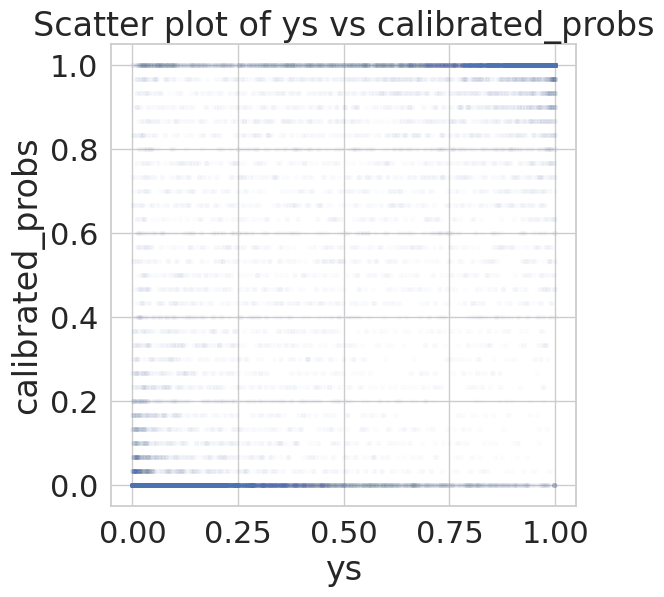

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(calibrated_probs, ys, alpha=0.01, s=8)
plt.xlabel("ys")
plt.ylabel("calibrated_probs")
plt.title("Scatter plot of ys vs calibrated_probs")
plt.grid(True)
plt.show()


In [9]:
df_test['calibrated_probs'] = calibrated_probs

bin
(-0.001, 0.0333]    5402
(0.0333, 0.0667]    2162
(0.0667, 0.1]       1356
(0.1, 0.133]         987
(0.133, 0.167]       700
(0.167, 0.2]         608
(0.2, 0.233]         517
(0.233, 0.267]       475
(0.267, 0.3]         418
(0.3, 0.333]         428
(0.333, 0.367]       402
(0.367, 0.4]         390
(0.4, 0.433]         350
(0.433, 0.467]       347
(0.467, 0.5]         334
(0.5, 0.533]         304
(0.533, 0.567]       302
(0.567, 0.6]         296
(0.6, 0.633]         311
(0.633, 0.667]       336
(0.667, 0.7]         310
(0.7, 0.733]         335
(0.733, 0.767]       323
(0.767, 0.8]         379
(0.8, 0.833]         426
(0.833, 0.867]       445
(0.867, 0.9]         481
(0.9, 0.933]         653
(0.933, 0.967]       803
(0.967, 1.0]        1626
Name: count, dtype: int64


/tmp/ipykernel_1451554/367782362.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


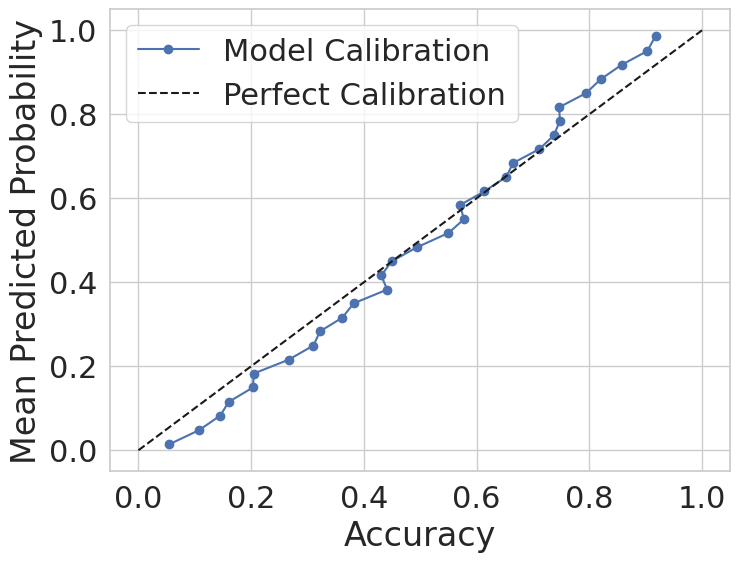

In [ ]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability")
# plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.


we obtain a predicted cost by taking an average of points across the training set.

In [10]:
# Create new columns for predicted token count and time based on group means
group_means = df_train.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means = group_means.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})

# Merge these means back into df_test
df_test = df_test.merge(group_means, on=["method", "N", "beam_width", "max_iteration"], how="left")

In [16]:
df_test.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted,calibrated_probs,bin,token_count_pred,time_pred
0,"Given that $b$ is a multiple of $2373$, find t...",beam_search,2.0,2.0,40.0,0.0,928,3.41,3679,True,False,False,False,0.712480,"(0.7, 0.733]",1484.315171,5.847008
1,"In triangle $ABC$, $CA = CB$, and $D$ is the m...",beam_search,2.0,2.0,40.0,0.0,1441,4.93,5998,True,False,False,False,0.929762,"(0.9, 0.933]",1484.315171,5.847008
2,"At its Grand Opening, the Guthrie Market distr...",beam_search,2.0,2.0,40.0,1.0,861,3.37,1426,True,False,False,False,0.346296,"(0.333, 0.367]",1484.315171,5.847008
3,"Let \( p = 2^{3009}, q = 3^{2006}, \) and \( r...",beam_search,2.0,2.0,40.0,1.0,1387,5.09,6860,True,False,False,False,0.020976,"(-0.001, 0.0333]",1484.315171,5.847008
4,"Given the function $f(x)=x\ln x$, if $0 \lt x_...",beam_search,2.0,2.0,40.0,0.0,2371,8.12,4236,True,False,False,False,0.108261,"(0.1, 0.133]",1484.315171,5.847008


In [17]:
group_means.head(20)

,method,N,beam_width,max_iteration,token_count_pred,time_pred
0,beam_search,2.0,2.0,40.0,1484.315171,5.847008
1,beam_search,4.0,2.0,40.0,3565.782804,10.506026
2,beam_search,4.0,4.0,40.0,3583.333333,10.800000
3,beam_search,8.0,4.0,20.0,7118.774306,13.948145
4,beam_search,16.0,2.0,40.0,21465.719820,42.911500
5,beam_search,16.0,4.0,20.0,15331.905774,24.462464
6,beam_search,32.0,2.0,20.0,34825.430892,49.405381
7,beam_search,32.0,4.0,40.0,49158.522869,92.089523
8,majority,2.0,0.0,0.0,1164.029611,3.205739
9,majority,4.0,0.0,0.0,2340.723965,3.826848


In [11]:
# get the average accuracy and token_count for each configuration.
config_summary_df = df_test.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "time", "sl", "calibrated_probs", "token_count_pred", "time_pred"]
].mean().reset_index()

In [12]:
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred
0,2.0,0.0,0.0,majority,1161.653202,3.118414,0.261117,0.283097,1164.029611,3.205739
1,2.0,0.0,0.0,naive,1161.653202,3.237714,0.311494,0.304863,1164.029611,3.327415
2,2.0,0.0,0.0,weighted,1161.653202,3.237714,0.311494,0.314541,1164.029611,3.327415
3,2.0,2.0,40.0,beam_search,1473.004012,5.827904,0.328987,0.341117,1484.315171,5.847008
4,4.0,0.0,0.0,majority,2307.248276,3.745695,0.310739,0.289726,2340.723965,3.826848


In [13]:
# remove incomplete configurations (there is not enough data using these configs, to compare to other configurations fairly).
config_summary_df = config_summary_df[~(
    ((config_summary_df['N'] == 4) & (config_summary_df['beam_width'] == 4) & (config_summary_df['max_iteration'] == 40)) |
    ((config_summary_df['N'] == 8) & (config_summary_df['beam_width'] == 4) & (config_summary_df['max_iteration'] == 40))
)]

Route for a given lambda.

In [14]:
def compute_max_utility_pred(df, lambda_, method="oracle", costa="token_count", costb="time", fixed_lambda=0):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"],
            "method": group.loc[idx_max, "method"] # sept 3rd. added method.
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

Route for a list of lambdas.

In [16]:
def get_router_df(input_df, lambda_list, method="oracle", costa="token_count", costb="time", fixed_lambda=0):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, costa, costb, fixed_lambda)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean() # average over all questions in test set for adaptive router.
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "predicted_prob": average_predicted_prob,
            "token_count": average_cost,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df

In [ ]:
oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="oracle", costa="token_count", costb="time", fixed_lambda=0)
oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="oracle", costa="time", costb="token_count", fixed_lambda=0)

adaptive_tc_0 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=0)
adaptive_lat_0 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=0)

adaptive_tc_4 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-4)
adaptive_lat_4 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-4)

adaptive_tc_3 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-3)
adaptive_lat_3 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-3)

adaptive_tc_2 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-2)
adaptive_lat_2 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-2)

# adaptive_oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count", costb="time", fixed_lambda=1e-5)
# adaptive_oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", costa="time", costb="token_count", fixed_lambda=1e-5)
# adaptive_lat_ = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-5)
# oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="oracle", costa="token_count", costb="time", fixed_lambda=1e-5)
# adaptive_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-5)
# adaptive_oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", costa="token_count", costb="time", fixed_lambda=1e-5)

# adaptive_oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", costa="time", costb="token_count", fixed_lambda=1e-5)
# adaptive_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-5)
# oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="oracle", costa="time", costb="token_count", fixed_lambda=1e-5)

/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [19]:
# adaptive_tc_4 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-4)
adaptive_lat_7 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-7)

# adaptive_tc_3 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-3)
adaptive_lat_6 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-6)

# adaptive_tc_2 = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=1e-2)
adaptive_lat_5 = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=1e-5)

/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2726040/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

Fill in "-1"'s for the configuration-related columns for the router + oracle.

In [20]:
oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

adaptive_tc_0['N'] = -1
adaptive_tc_0['beam_width'] = -1
adaptive_tc_0['max_iteration'] = -1

adaptive_lat_0['N'] = -1
adaptive_lat_0['beam_width'] = -1
adaptive_lat_0['max_iteration'] = -1

adaptive_tc_2['N'] = -1
adaptive_tc_2['beam_width'] = -1
adaptive_tc_2['max_iteration'] = -1

adaptive_lat_2['N'] = -1
adaptive_lat_2['beam_width'] = -1
adaptive_lat_2['max_iteration'] = -1

adaptive_tc_3['N'] = -1
adaptive_tc_3['beam_width'] = -1
adaptive_tc_3['max_iteration'] = -1

adaptive_lat_3['N'] = -1
adaptive_lat_3['beam_width'] = -1
adaptive_lat_3['max_iteration'] = -1

adaptive_tc_4['N'] = -1
adaptive_tc_4['beam_width'] = -1
adaptive_tc_4['max_iteration'] = -1

adaptive_lat_4['N'] = -1
adaptive_lat_4['beam_width'] = -1
adaptive_lat_4['max_iteration'] = -1


In [21]:
adaptive_lat_5['N'] = -1  
adaptive_lat_6['N'] = -1
adaptive_lat_7['N'] = -1

adaptive_lat_5['beam_width'] = -1
adaptive_lat_6['beam_width'] = -1
adaptive_lat_7['beam_width'] = -1

adaptive_lat_5['max_iteration'] = -1
adaptive_lat_6['max_iteration'] = -1
adaptive_lat_7['max_iteration'] = -1

In [22]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)

In [ ]:
# config_summary_df = config_summary_df.drop(columns=["token_count_pred", "time_pred"]) # these columns are only used for adaptive routing.
# config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
0,2.0,0.0,0.0,majority,1161.653202,3.118414,0.261117,0.283097
1,2.0,0.0,0.0,naive,1161.653202,3.237714,0.311494,0.304863
2,2.0,0.0,0.0,weighted,1161.653202,3.237714,0.311494,0.314541
3,2.0,2.0,40.0,beam_search,1473.004012,5.827904,0.328987,0.341117
4,4.0,0.0,0.0,majority,2307.248276,3.745695,0.310739,0.289726


In [23]:
adaptive_tc_0['method'] = 'adaptive_router_0'
adaptive_tc_2['method'] = 'adaptive_router_2'
adaptive_tc_3['method'] = 'adaptive_router_3'
adaptive_tc_4['method'] = 'adaptive_router_4'
adaptive_lat_0['method'] = 'adaptive_router_0'
adaptive_lat_2['method'] = 'adaptive_router_2'
adaptive_lat_3['method'] = 'adaptive_router_3'
adaptive_lat_4['method'] = 'adaptive_router_4'
adaptive_lat_5['method'] = 'adaptive_router_5'
adaptive_lat_6['method'] = 'adaptive_router_6'
adaptive_lat_7['method'] = 'adaptive_router_7'


In [38]:
oracle_tc.head()

,lambda,sl,predicted_prob,token_count,time,method,N,beam_width,max_iteration
0,1.000000e-07,0.578782,0.394399,5799.483056,9.379017,oracle,-1,-1,-1
1,1.778279e-07,0.578782,0.394399,5799.483056,9.379017,oracle,-1,-1,-1
2,3.162278e-07,0.578782,0.394399,5799.483056,9.379017,oracle,-1,-1,-1
3,5.623413e-07,0.578693,0.394276,5591.865781,8.979914,oracle,-1,-1,-1
4,1.000000e-06,0.578560,0.394161,5406.594020,8.579515,oracle,-1,-1,-1


In [39]:
adaptive_tc_0.head()

,lambda,sl,predicted_prob,token_count,time,method,N,beam_width,max_iteration
0,1.000000e-07,0.494219,0.514166,29585.962126,42.936545,adaptive_router_0,-1,-1,-1
1,1.778279e-07,0.493068,0.513985,28231.088372,40.579767,adaptive_router_0,-1,-1,-1
2,3.162278e-07,0.492979,0.513575,26576.605316,37.828678,adaptive_router_0,-1,-1,-1
3,5.623413e-07,0.489214,0.512485,24087.477076,33.784352,adaptive_router_0,-1,-1,-1
4,1.000000e-06,0.482746,0.510055,20783.985382,28.839615,adaptive_router_0,-1,-1,-1


In [ ]:
# adaptive_oracle_tc['method'] = 'oracle_cost'
# adaptive_oracle_lat['method'] = 'oracle_cost'

In [ ]:
# config_summary_df = config_summary_df.drop(columns=["token_count_pred", "time_pred"])
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
0,2.0,0.0,0.0,majority,1161.653202,3.118414,0.261117,0.283097
1,2.0,0.0,0.0,naive,1161.653202,3.237714,0.311494,0.304863
2,2.0,0.0,0.0,weighted,1161.653202,3.237714,0.311494,0.314541
3,2.0,2.0,40.0,beam_search,1473.004012,5.827904,0.328987,0.341117
4,4.0,0.0,0.0,majority,2307.248276,3.745695,0.310739,0.289726


In [24]:
# merge all token count dataframes.
query_optimal_tc = pd.concat(
    [config_summary_df, adaptive_tc_0, adaptive_tc_2, adaptive_tc_3, adaptive_tc_4, oracle_tc],
    axis=0,          # stack them vertically (rows)
    ignore_index=True  # reset the index
)

In [ ]:
query_optimal_tc['method'].unique()

array(['majority', 'naive', 'weighted', 'beam_search',
       'adaptive_router_0', 'adaptive_router_2', 'adaptive_router_3',
       'adaptive_router_4', 'oracle'], dtype=object)

In [26]:
# merge all latency dataframes.
query_optimal_late = pd.concat(
    [config_summary_df, adaptive_lat_5, adaptive_lat_6, adaptive_lat_7, adaptive_lat_0, oracle_lat],
    axis=0,          # stack them vertically (rows)
    ignore_index=True  # reset the index
)

In [27]:
query_optimal_late['method'].unique()

array(['majority', 'naive', 'weighted', 'beam_search',
       'adaptive_router_5', 'adaptive_router_6', 'adaptive_router_7',
       'adaptive_router_0', 'oracle'], dtype=object)

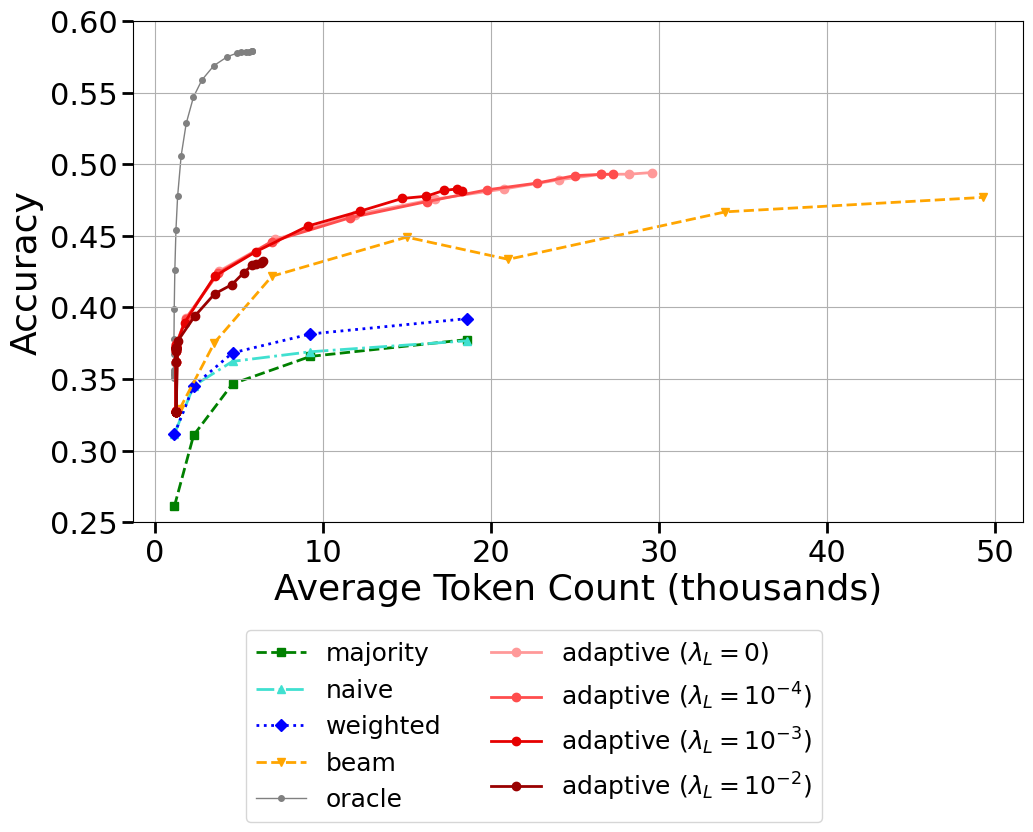

In [29]:
# router on latency, cross sections with various lambda values.
# Use different shades of red for each adaptive_router variant
import matplotlib.pyplot as plt

# Plot for token_count (cost) vs accuracy, using the same style as the latency plot above

method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router_2": "#990000",  # very dark red
    "adaptive_router_3": "#e60000",  # dark red
    "adaptive_router_4": "#ff4d4d",  # medium red
    "adaptive_router_0": "#ff9999",  # light red
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Mapping for pretty legend names for adaptive_router_X
adaptive_router_legend = {
    "adaptive_router_0": r"adaptive ($\lambda_L  = 0$)",
    "adaptive_router_2": r"adaptive ($\lambda_L = 10^{-2}$)",
    "adaptive_router_3": r"adaptive ($\lambda_L = 10^{-3}$)",
    "adaptive_router_4": r"adaptive ($\lambda_L = 10^{-4}$)",
    "beam_search": r"beam",
}

# Marker and linestyle mapping for specific methods
method_markers = {
    "majority": ("s", "--"),   # square, dashed
    "naive": ("^", "-."),      # triangle_up, dash-dot
    "weighted": ("D", ":"),    # diamond, dotted
    "beam_search": ("v", "--"), # triangle_down, dashed
}
default_marker = "o"
default_linestyle = "-"

plt.figure(figsize=(10, 6))

handles = []
labels = []

# Define the plotting order for adaptive_router_X to control z-order
adaptive_router_order = ["adaptive_router_0", "adaptive_router_4", "adaptive_router_3", "adaptive_router_2"]

# First, plot all non-adaptive_router_X methods (except oracle_cost)
for method in query_optimal_tc["method"].unique():
    if not method.startswith("adaptive_router_") and method != "oracle_cost":
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "gray")
        marker, linestyle = method_markers.get(method, (default_marker, default_linestyle))
        if method == "beam_search":
            label = adaptive_router_legend.get(method, method)
        else:
            label = method
        # Plot token_count in thousands
        h, = plt.plot(
            method_df["token_count"] / 1000, 
            method_df["sl"], 
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=label,
            markersize=6 if method in method_markers else 4,
            linewidth=2 if method in method_markers else 1,
            zorder=1
        )
        handles.append(h)
        labels.append(label)

# Then, plot adaptive_router_X in the desired order so that 2 is on top, then 3, then 4, then 0
for idx, method in enumerate(adaptive_router_order):
    if method in query_optimal_tc["method"].unique():
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "red")
        label = adaptive_router_legend.get(method, method)
        # zorder increases with idx, so last (adaptive_router_2) is on top
        # Plot token_count in thousands
        h, = plt.plot(
            method_df["token_count"] / 1000, 
            method_df["sl"], 
            marker=default_marker, 
            linestyle=default_linestyle, 
            color=color, 
            label=label,
            markersize=6,
            linewidth=2,
            zorder=10 + idx  # ensure these are above the others
        )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Accuracy", fontsize=26)
plt.grid(True)
plt.ylim(0.25, 0.6)
plt.tight_layout()

plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

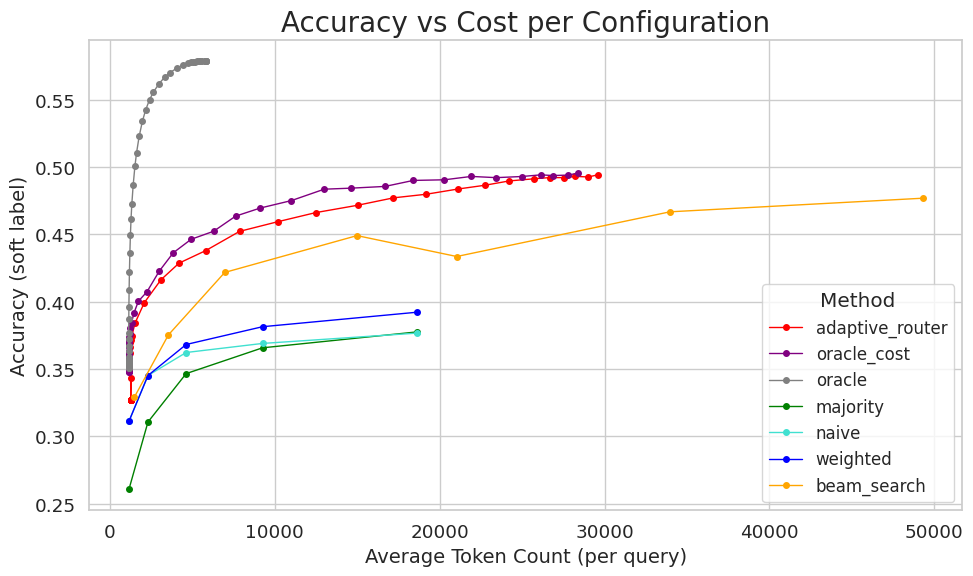

In [ ]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

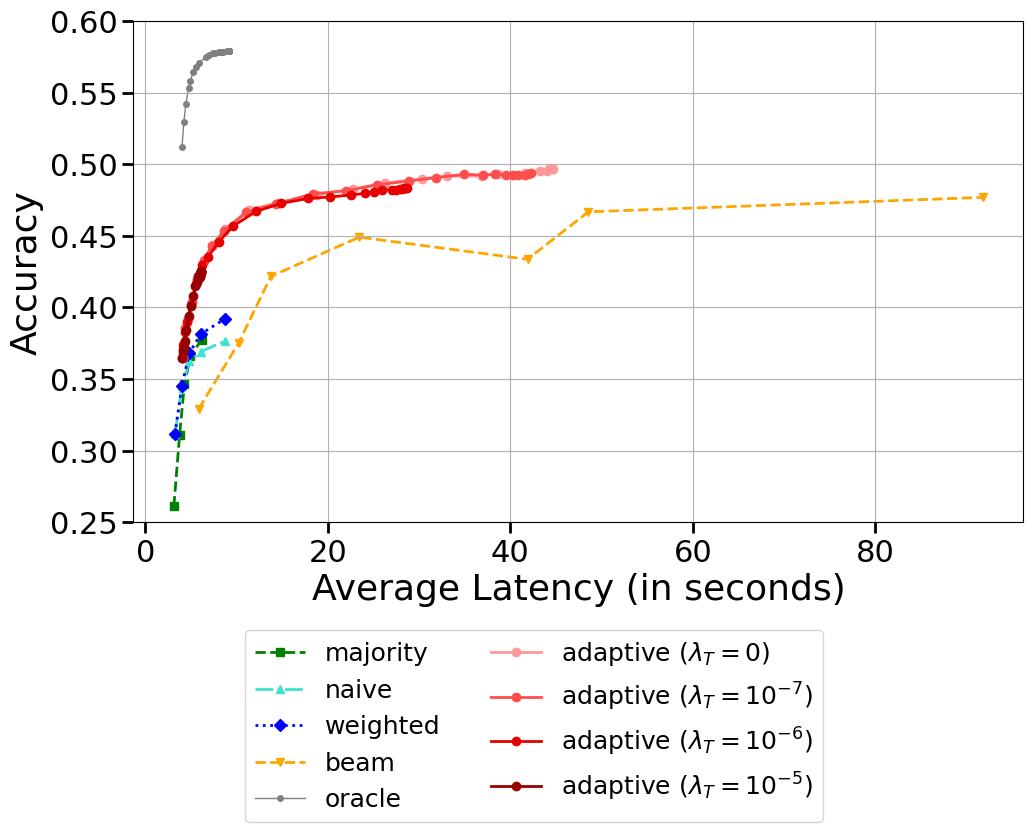

In [30]:
# router on latency, cross sections with various lambda values.
# Use different shades of red for each adaptive_router variant

method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router_5": "#990000",  # very dark red
    "adaptive_router_6": "#e60000",  # dark red
    "adaptive_router_7": "#ff4d4d",  # medium red
    "adaptive_router_0": "#ff9999",  # light red
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Mapping for pretty legend names for adaptive_router_X
adaptive_router_legend = {
    "adaptive_router_0": r"adaptive ($\lambda_T  = 0$)",
    "adaptive_router_5": r"adaptive ($\lambda_T = 10^{-5}$)",
    "adaptive_router_6": r"adaptive ($\lambda_T = 10^{-6}$)",
    "adaptive_router_7": r"adaptive ($\lambda_T = 10^{-7}$)",
    "beam_search": r"beam",
}

# Marker and linestyle mapping for specific methods
method_markers = {
    "majority": ("s", "--"),   # square, dashed
    "naive": ("^", "-."),      # triangle_up, dash-dot
    "weighted": ("D", ":"),    # diamond, dotted
    "beam_search": ("v", "--"), # triangle_down, dashed
}
default_marker = "o"
default_linestyle = "-"

plt.figure(figsize=(10, 6))

handles = []
labels = []

# Define the plotting order for adaptive_router_X to control z-order
adaptive_router_order = ["adaptive_router_0", "adaptive_router_7", "adaptive_router_6", "adaptive_router_5"]

# First, plot all non-adaptive_router_X methods (except oracle_cost)
for method in query_optimal_late["method"].unique():
    if not method.startswith("adaptive_router_") and method != "oracle_cost":
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "gray")
        marker, linestyle = method_markers.get(method, (default_marker, default_linestyle))
        if method == "beam_search":
            label = adaptive_router_legend.get(method, method)
        else:
            label = method
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=label,
            markersize=6 if method in method_markers else 4,
            linewidth=2 if method in method_markers else 1,
            zorder=1
        )
        handles.append(h)
        labels.append(label)

# Then, plot adaptive_router_X in the desired order so that 5 is on top, then 6, then 7, then 0
for idx, method in enumerate(adaptive_router_order):
    if method in query_optimal_late["method"].unique():
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "red")
        label = adaptive_router_legend.get(method, method)
        # zorder increases with idx, so last (adaptive_router_5) is on top
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=default_marker, 
            linestyle=default_linestyle, 
            color=color, 
            label=label,
            markersize=6,
            linewidth=2,
            zorder=10 + idx  # ensure these are above the others
        )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Latency (in seconds)", fontsize=26)
plt.ylabel("Accuracy", fontsize=26)
plt.grid(True)
plt.ylim(0.25, 0.6)
plt.tight_layout()

plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

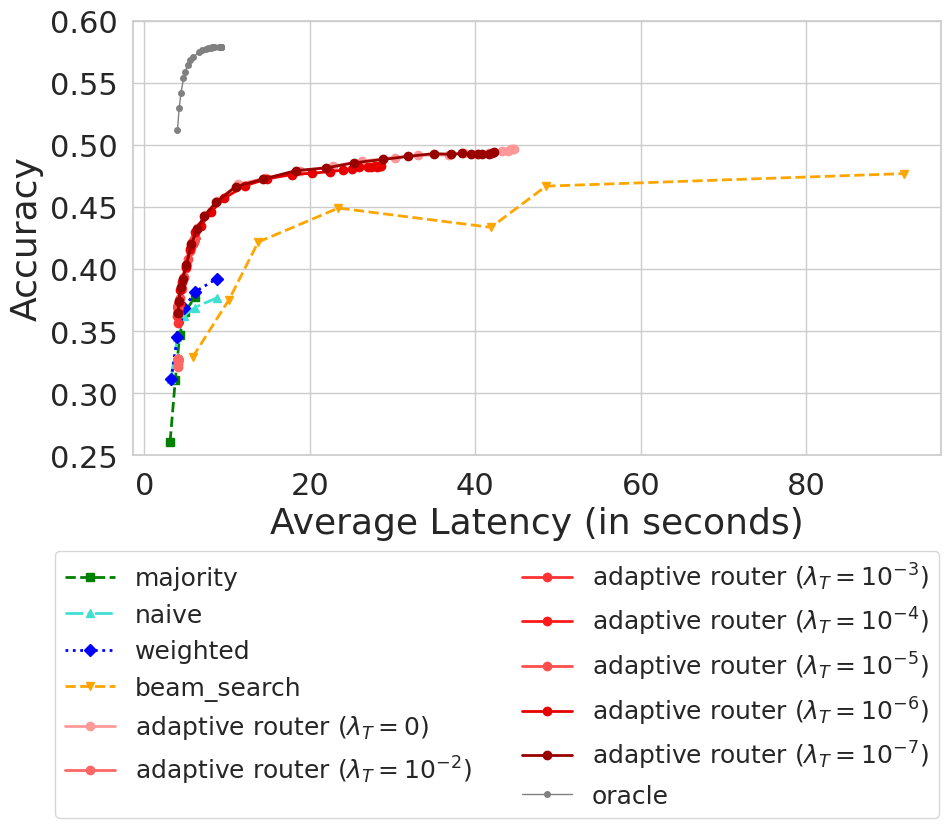

In [79]:
# router on latency, cross sections with various lambda values.
# Use different shades of red for each adaptive_router variant, including 2, 3, 4

method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router_0": "#ff9999",  # light red
    "adaptive_router_2": "#ff6666",  # slightly deeper light red
    "adaptive_router_3": "#ff3333",  # medium-light red
    "adaptive_router_4": "#ff1a1a",  # medium red
    "adaptive_router_5": "#ff4d4d",  # medium red (original)
    "adaptive_router_6": "#e60000",  # dark red
    "adaptive_router_7": "#990000",  # very dark red
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Mapping for pretty legend names for adaptive_router_X
adaptive_router_legend = {
    "adaptive_router_0": r"adaptive router ($\lambda_T  = 0$)",
    "adaptive_router_2": r"adaptive router ($\lambda_T = 10^{-2}$)",
    "adaptive_router_3": r"adaptive router ($\lambda_T = 10^{-3}$)",
    "adaptive_router_4": r"adaptive router ($\lambda_T = 10^{-4}$)",
    "adaptive_router_5": r"adaptive router ($\lambda_T = 10^{-5}$)",
    "adaptive_router_6": r"adaptive router ($\lambda_T = 10^{-6}$)",
    "adaptive_router_7": r"adaptive router ($\lambda_T = 10^{-7}$)",
    "beam_search": r"beam search",
}

# Marker and linestyle mapping for specific methods
method_markers = {
    "majority": ("s", "--"),   # square, dashed
    "naive": ("^", "-."),      # triangle_up, dash-dot
    "weighted": ("D", ":"),    # diamond, dotted
    "beam_search": ("v", "--"), # triangle_down, dashed
}
default_marker = "o"
default_linestyle = "-"

# Create a figure
plt.figure(figsize=(10, 6))

# Store handles and labels for custom legend
handles = []
labels = []

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    # Plot each adaptive_router_X with its own color and pretty legend name
    if method.startswith("adaptive_router_"):
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "red")  # Default to red if not found
        label = adaptive_router_legend.get(method, method)
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=default_marker, 
            linestyle=default_linestyle, 
            color=color, 
            label=label,
            markersize=6,
            linewidth=2
        )
        handles.append(h)
        labels.append(label)
    elif method != "oracle_cost":
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "gray")  # Default to gray if method is unknown
        marker, linestyle = method_markers.get(method, (default_marker, default_linestyle))
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=method,
            markersize=6 if method in method_markers else 4,
            linewidth=2 if method in method_markers else 1
        )
        handles.append(h)
        labels.append(method)

# Add labels and title with increased font size for x and y axis labels
plt.xlabel("Average Latency (in seconds)", fontsize=26)
plt.ylabel("Accuracy", fontsize=26)
# plt.title("Latency-aware router", fontsize=20)
plt.grid(True)
plt.ylim(0.25, 0.6)
plt.tight_layout()

# Place the legend below the figure, without a title
plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.19),
    ncol=2,
    frameon=True
)

# Increase the size of the tick marks
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

# Show the plot
plt.show()

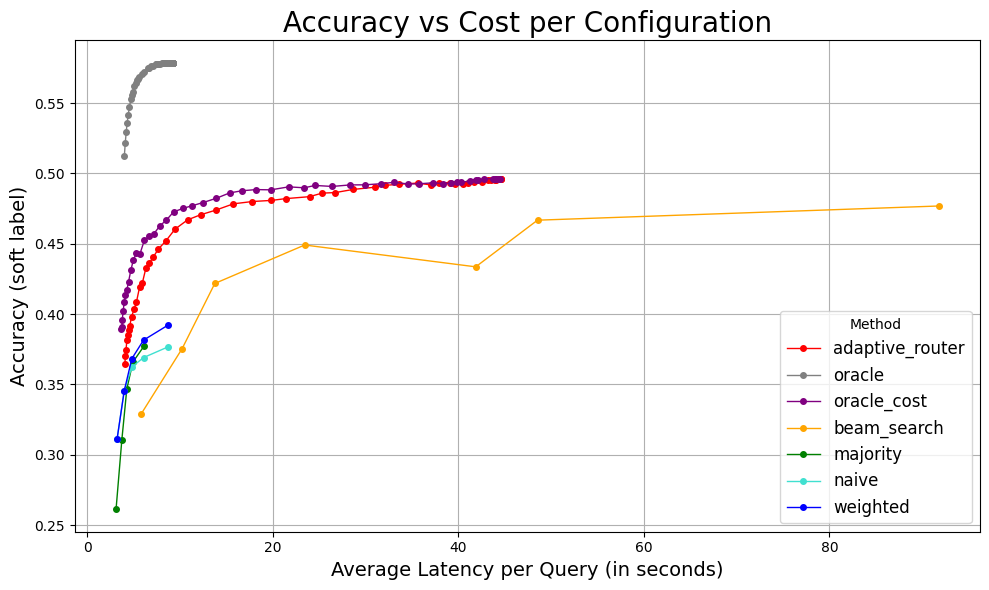

In [ ]:
# Router on latency.
method_colors = {
    "oracle_cost": "purple",
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["time"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Latency per Query (in seconds)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

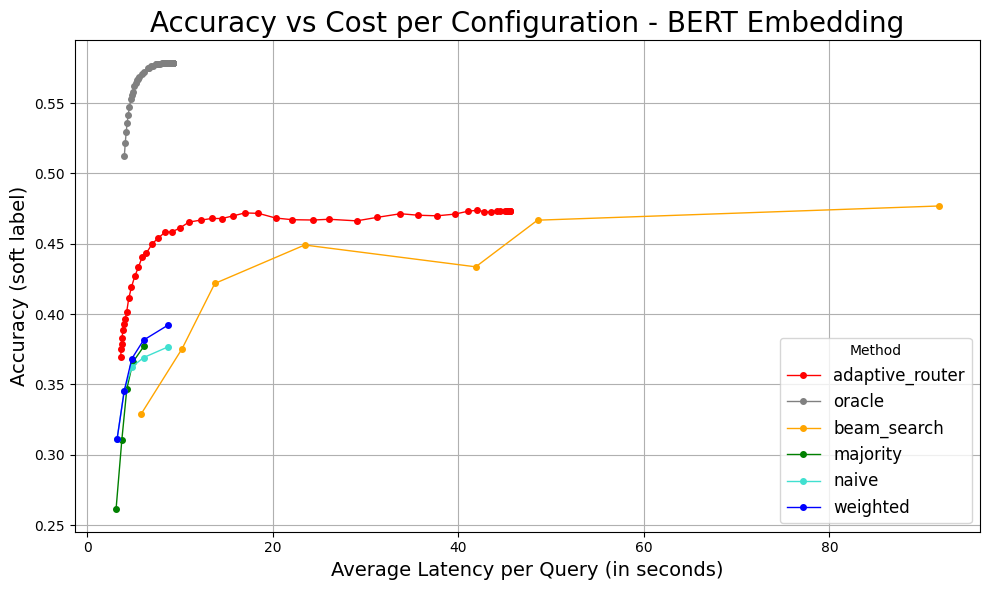

In [ ]:
# Router on latency.
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["time"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Latency per Query (in seconds)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration - BERT Embedding", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Plot accuracies on the test set (the dataset that routing was performed on).

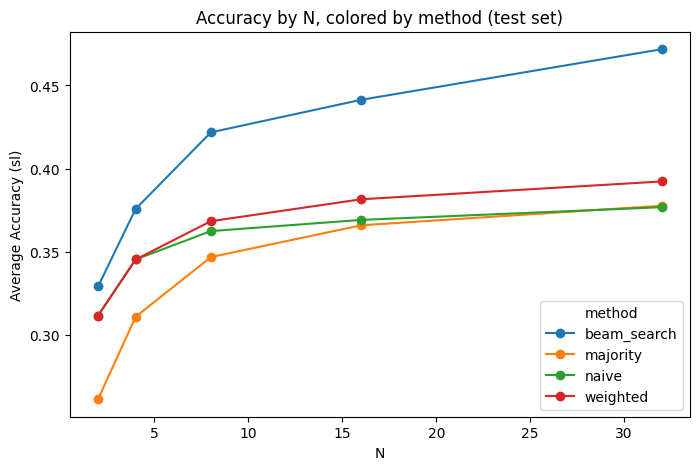

In [ ]:
import matplotlib.pyplot as plt

avg_acc = df_test.groupby(["N", "method"])["sl"].mean().reset_index()
plt.figure(figsize=(8,5))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(group_sorted["N"], group_sorted["sl"], marker="o", label=method)
plt.xlabel("N")
plt.ylabel("Average Accuracy (sl)")
plt.title("Accuracy by N, colored by method (test set)")
plt.legend(title="method")
plt.show()

In [ ]:
len(df_test['sb_idx'].unique())

1505

In [47]:
# adaptive router by token count penalty.
# Plot progression of method distribution as lambda increases from 0 to 1,
# with y-axis as the proportion of questions out of total unique sb_idx.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-10, -1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    # compute_max_utility_pred(input_df, lambda_value, method, costa, costb, fixed_lambda)
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "token_count_pred", "time_pred", fixed_lambda=0)


    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution as proportions
    method_distributions.append({
        'lambda': lambda_val,
        'majority': method_counts.get('majority', 0) / total_questions,
        'naive': method_counts.get('naive', 0) / total_questions,
        'weighted': method_counts.get('weighted', 0) / total_questions,
        'beam_search': method_counts.get('beam_search', 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1451554/51990131.py:19: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_T$', fontsize=35)


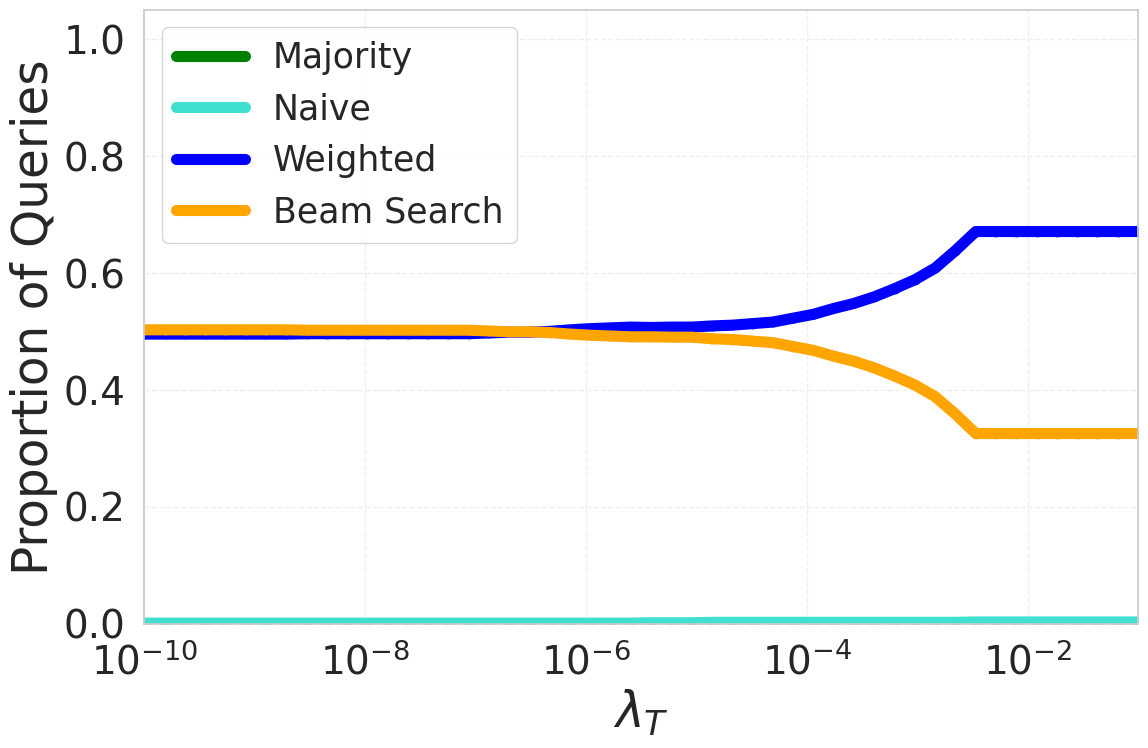

In [ ]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method as a line
methods = ['majority', 'naive', 'weighted', 'beam_search']
colors = ['green', 'turquoise', 'blue', 'orange']

for method, color in zip(methods, colors):
    plt.plot(dist_df['lambda'], dist_df[method], 
             label=method.replace('_', ' ').title(), 
             color=color, linewidth=8, marker='o', markersize=6)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, 1.05)

plt.xlabel('$\lambda_T$', fontsize=35)
plt.ylabel('Proportion of Queries', fontsize=35)
# plt.title('Choice Distribution as Cost Weight on Token Count Increases: Adaptive Router', fontsize=16)
plt.legend(title='', fontsize=25, title_fontsize=25)  # Remove the word "Method" from the legend
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
plt.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)

plt.tight_layout()
plt.show()

In [ ]:
# adaptive router by time penalty.
# Plot progression of method distribution as lambda increases from 0 to 1,
# with y-axis as the proportion of questions out of total unique sb_idx.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-5, 1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "time_pred")
    # oracle_router = compute_max_utility_pred(df_test, lambda_val, "oracle", "time")

    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution as proportions
    method_distributions.append({
        'lambda': lambda_val,
        'majority': method_counts.get('majority', 0) / total_questions,
        'naive': method_counts.get('naive', 0) / total_questions,
        'weighted': method_counts.get('weighted', 0) / total_questions,
        'beam_search': method_counts.get('beam_search', 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

# # Create the plot
# plt.figure(figsize=(12, 8))

# # Plot each method as a line
# methods = ['majority', 'naive', 'weighted', 'beam_search']
# colors = ['green', 'turquoise', 'blue', 'orange']

# for method, color in zip(methods, colors):
#     plt.plot(dist_df['lambda'], dist_df[method], 
#              label=method.replace('_', ' ').title(), 
#              color=color, linewidth=2, marker='o', markersize=4)

# plt.xscale('log')  # Set x-axis to log scale

# # Optionally adjust axis limits to fit data better
# plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
# plt.ylim(0, 1.05)

# plt.xlabel('Cost Weight (log scale)', fontsize=14)
# plt.ylabel('Proportion of Questions Routed to Method', fontsize=14)
# plt.title('Choice Distribution as Cost Weight on Time Increases: Adaptive Router', fontsize=16)
# plt.legend(title='Method', fontsize=12)
# plt.grid(True, which='both', linestyle='--', alpha=0.3)
# plt.tight_layout()
# plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1451554/2876181665.py:19: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_L$', fontsize=35)


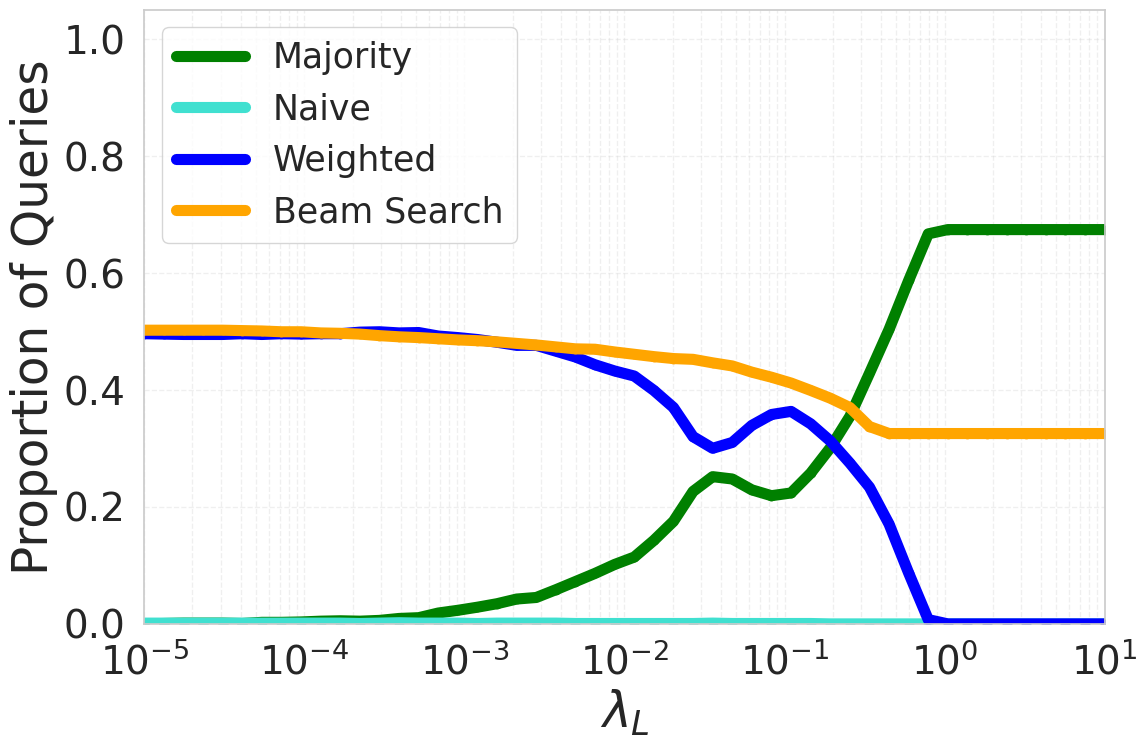

In [50]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method as a line
methods = ['majority', 'naive', 'weighted', 'beam_search']
colors = ['green', 'turquoise', 'blue', 'orange']

for method, color in zip(methods, colors):
    plt.plot(dist_df['lambda'], dist_df[method], 
             label=method.replace('_', ' ').title(), 
             color=color, linewidth=8, marker='o', markersize=6)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, 1.05)

plt.xlabel('$\lambda_L$', fontsize=35)
plt.ylabel('Proportion of Queries', fontsize=35)
# plt.title('Choice Distribution as Cost Weight on Token Count Increases: Adaptive Router', fontsize=16)
plt.legend(title='', fontsize=25, title_fontsize=25)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
plt.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)

plt.tight_layout()
plt.show()

<>:54: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1451554/2741990472.py:54: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_L$', fontsize=35)
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the groupi

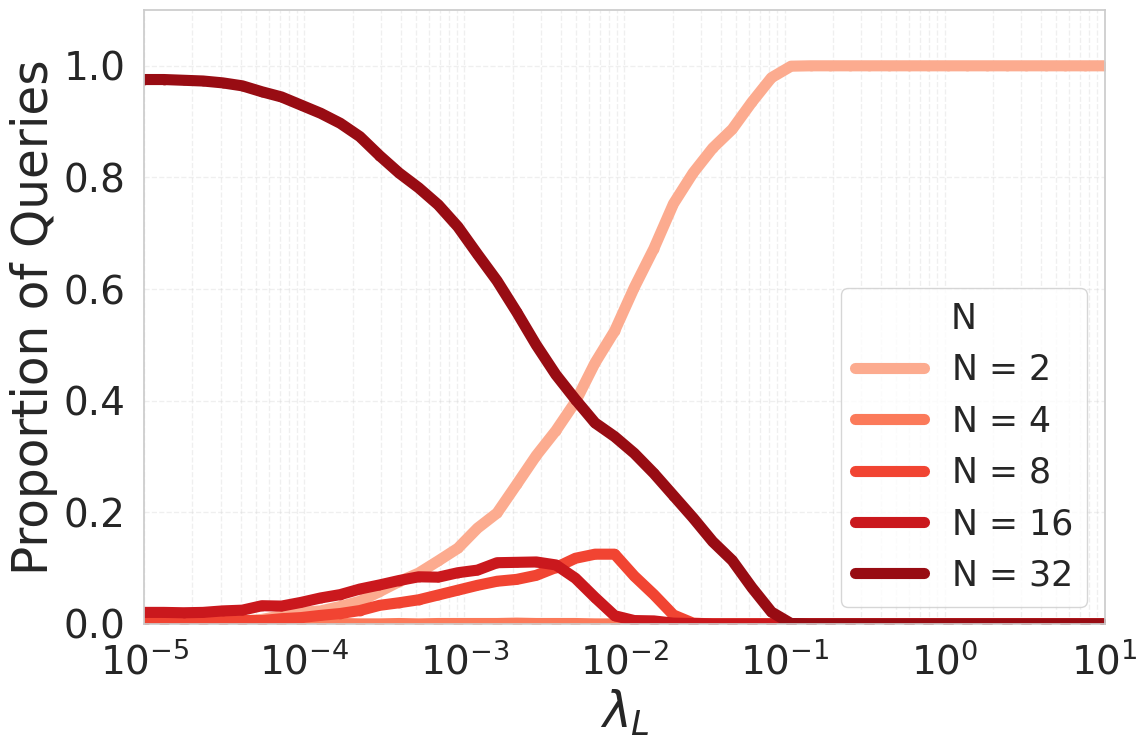

In [52]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-5, 1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    # oracle_router = compute_max_utility_pred(df_test, lambda_val, "oracle", "time")
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "time_pred")
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution (omit N=1)
    n_distributions.append({
        'lambda': lambda_val,
        'N_2': n_counts.get(2.0, 0) / total_questions,
        'N_4': n_counts.get(4.0, 0) / total_questions,
        'N_8': n_counts.get(8.0, 0) / total_questions,
        'N_16': n_counts.get(16.0, 0) / total_questions,
        'N_32': n_counts.get(32.0, 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_2', 'N_4', 'N_8', 'N_16', 'N_32']

# Use a red colormap for a gradient from light to dark red
import matplotlib
cmap = matplotlib.cm.get_cmap('Reds')
color_indices = np.linspace(0.3, 0.9, len(n_values))  # avoid too light/too dark
colors = [cmap(ci) for ci in color_indices]

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=8, marker='o', markersize=6)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('$\lambda_L$', fontsize=35)
plt.ylabel('Proportion of Queries', fontsize=35)
# plt.title('N Value Distribution as Cost Weight on Time Increases: Adaptive Router', fontsize=16)
plt.legend(title='N', fontsize=25, title_fontsize=25)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
plt.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)

plt.tight_layout()
plt.show()

In [51]:
df_test['N'].unique()

array([ 2.,  4.,  8., 16., 32.])

<>:53: SyntaxWarning: invalid escape sequence '\l'
<>:53: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1451554/1054701815.py:53: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_L$', fontsize=35)
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the groupi

/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1451554/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

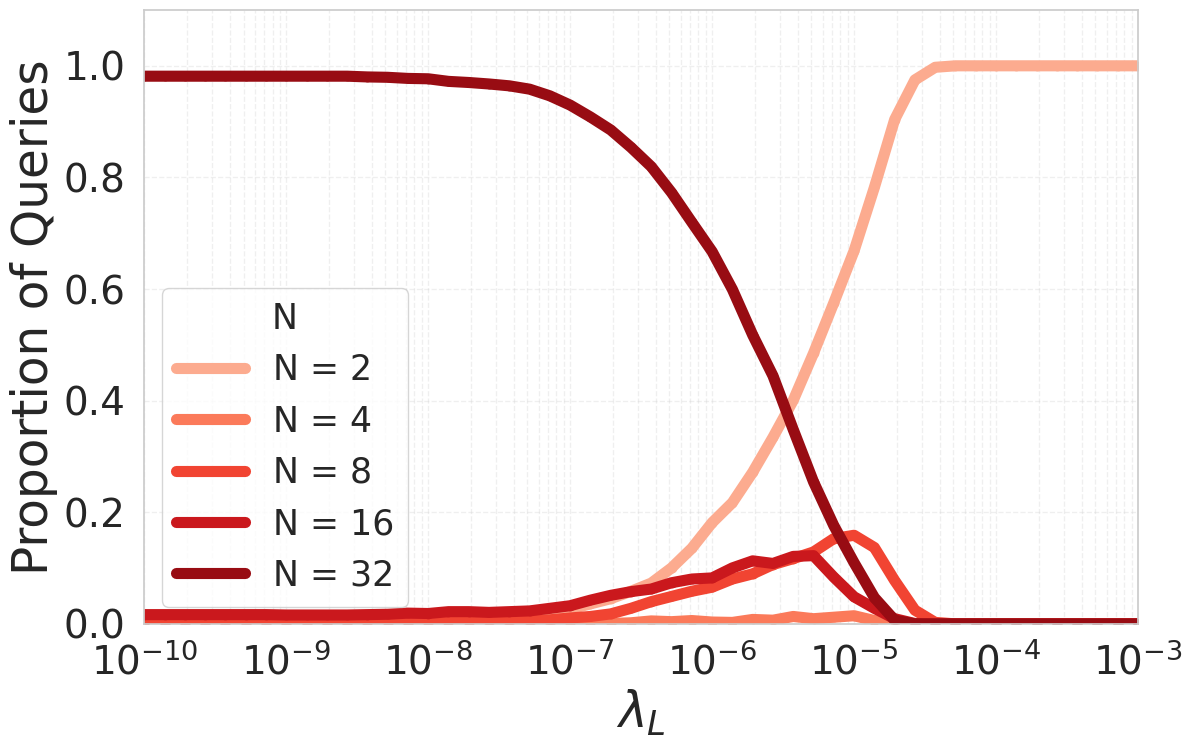

In [ ]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-10, -3, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda using token_count_pred
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "token_count_pred")
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution (omit N=1)
    n_distributions.append({
        'lambda': lambda_val,
        'N_2': n_counts.get(2.0, 0) / total_questions,
        'N_4': n_counts.get(4.0, 0) / total_questions,
        'N_8': n_counts.get(8.0, 0) / total_questions,
        'N_16': n_counts.get(16.0, 0) / total_questions,
        'N_32': n_counts.get(32.0, 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)


<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1451554/2364527795.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_T$', fontsize=35)
/tmp/ipykernel_1451554/2364527795.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Reds')


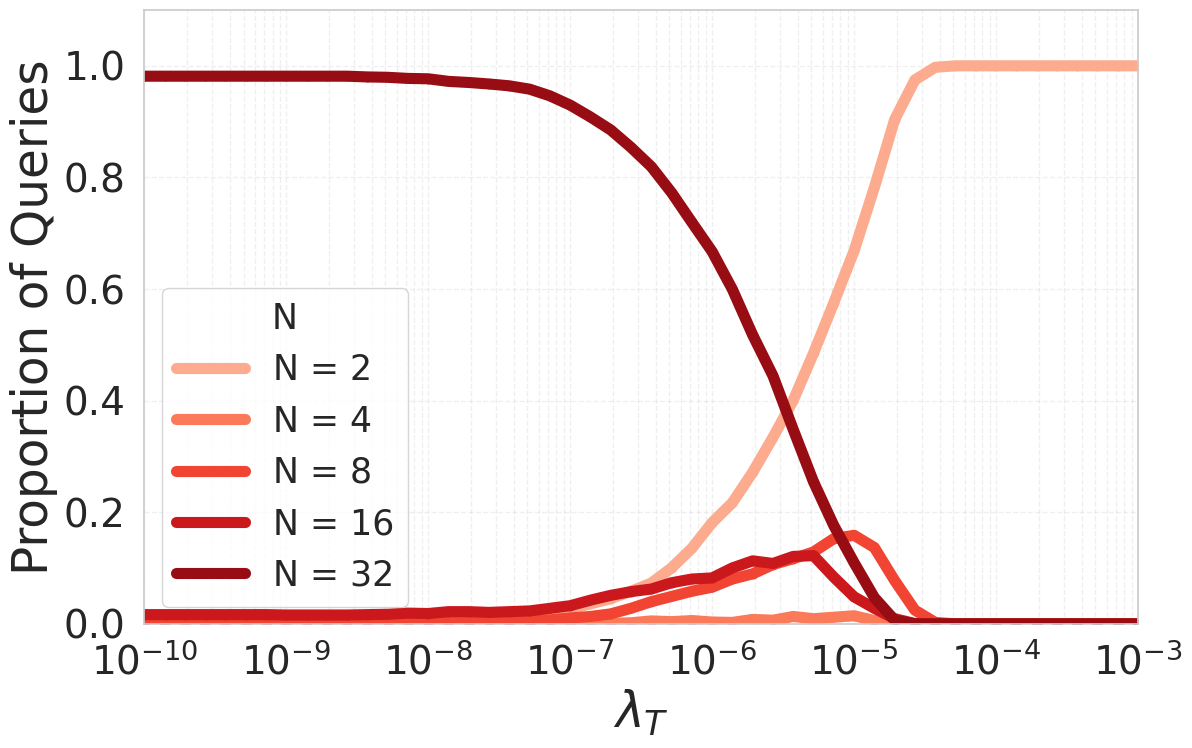

In [57]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_2', 'N_4', 'N_8', 'N_16', 'N_32']

# Use a red colormap for a gradient from light to dark red
import matplotlib
cmap = matplotlib.cm.get_cmap('Reds')
color_indices = np.linspace(0.3, 0.9, len(n_values))  # avoid too light/too dark
colors = [cmap(ci) for ci in color_indices]

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=8, marker='o', markersize=6)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('$\lambda_T$', fontsize=35)
plt.ylabel('Proportion of Queries', fontsize=35)
# plt.title('N Value Distribution as Cost Weight on Token Count Increases: Adaptive Router', fontsize=16)
plt.legend(title='N', fontsize=25, title_fontsize=25)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
plt.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)

plt.tight_layout()
plt.show()

<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_492856/2090061346.py:75: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda_T$', fontsize=35)
/tmp/ipykernel_492856/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_492856/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping 

/tmp/ipykernel_492856/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_492856/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_492856/2096964774.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping colum

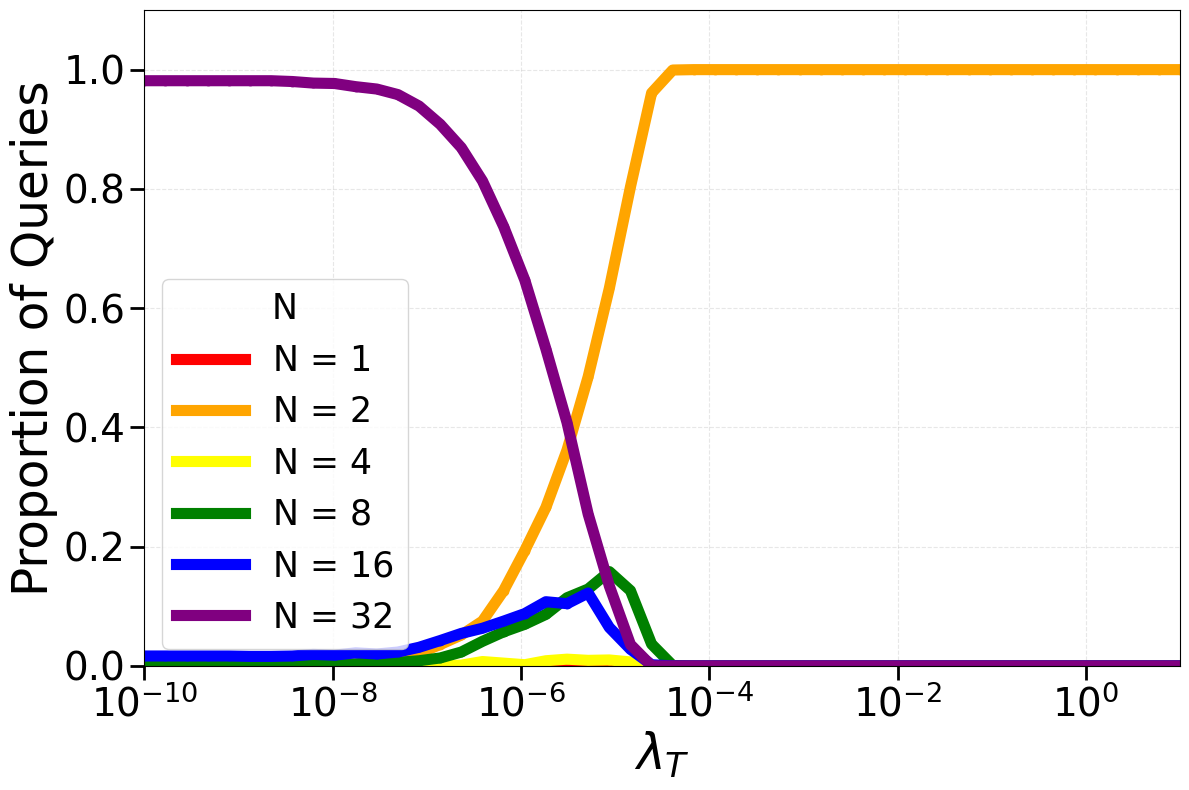

In [ ]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-10, 1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    # oracle_router = compute_max_utility_pred(df_test, lambda_val, "oracle", "time")
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "token_count_pred")
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution
    n_distributions.append({
        'lambda': lambda_val,
        'N_1': n_counts.get(1.0, 0) / total_questions,
        'N_2': n_counts.get(2.0, 0) / total_questions,
        'N_4': n_counts.get(4.0, 0) / total_questions,
        'N_8': n_counts.get(8.0, 0) / total_questions ,
        'N_16': n_counts.get(16.0, 0) / total_questions,
        'N_32': n_counts.get(32.0, 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# # Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_1', 'N_2', 'N_4', 'N_8', 'N_16', 'N_32']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=8, marker='o', markersize=6)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('$\lambda_T$', fontsize=35)
plt.ylabel('Proportion of Queries', fontsize=35)
# plt.title('N Value Distribution as Cost Weight on Time Increases: Adaptive Router', fontsize=16)
plt.legend(title='N', fontsize=25, title_fontsize=25)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
plt.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3615033/1558938243.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3615033/1558938243.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3615033/1558938243.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

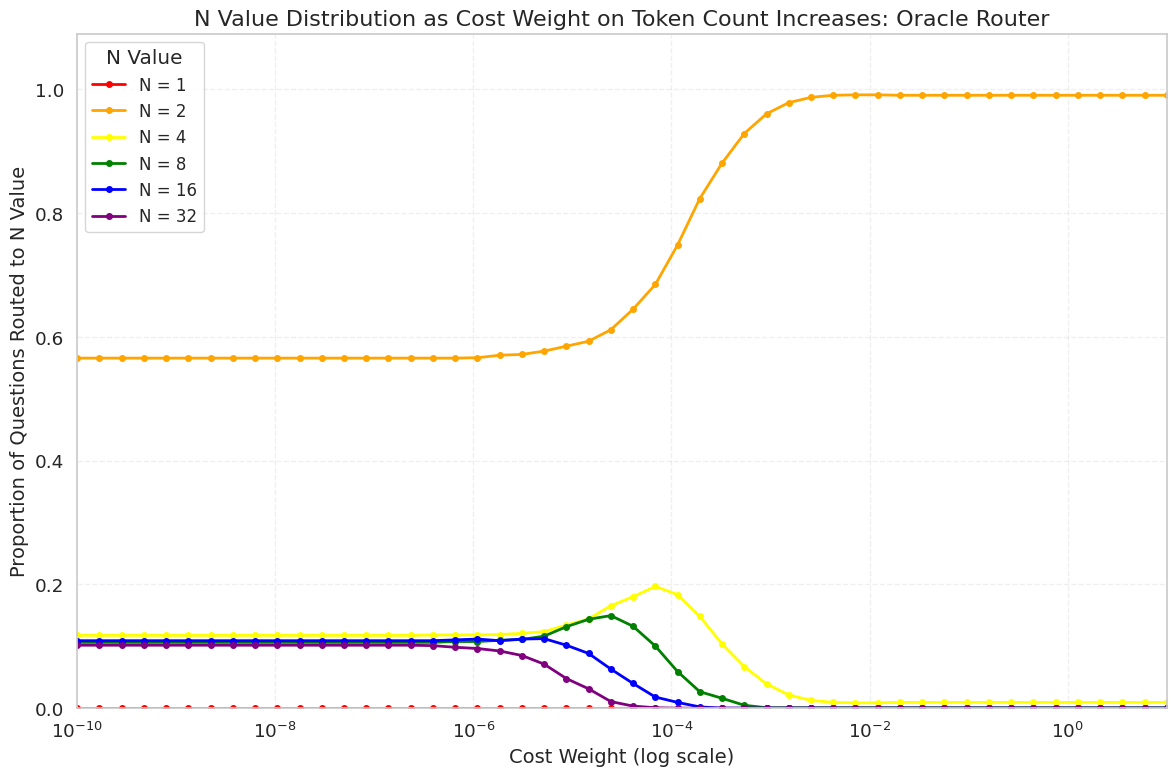

In [ ]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-10, 1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['sb_idx'].unique())

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    oracle_router = compute_max_utility_pred(df_test, lambda_val, "oracle", "token_count")
    # adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "token_count_pred")
    
    # Count the frequency of each N value
    n_counts = oracle_router['N'].value_counts()
    
    # Store the distribution
    n_distributions.append({
        'lambda': lambda_val,
        'N_1': n_counts.get(1.0, 0) / total_questions,
        'N_2': n_counts.get(2.0, 0) / total_questions,
        'N_4': n_counts.get(4.0, 0) / total_questions,
        'N_8': n_counts.get(8.0, 0) / total_questions ,
        'N_16': n_counts.get(16.0, 0) / total_questions,
        'N_32': n_counts.get(32.0, 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_1', 'N_2', 'N_4', 'N_8', 'N_16', 'N_32']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Proportion of Questions Routed to N Value', fontsize=14)
plt.title('N Value Distribution as Cost Weight on Token Count Increases: Oracle Router', fontsize=16)
plt.legend(title='N Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()